# Amino Data Science Challenge
The goal of this exercise is to give you a feel for data science at Amino and an opportunity to demonstrate your analytical and problem solving skills. The problems described here are ones we have worked on recently, and while the data provided is simulated and simplified, it is similar to the real data we have.

Please spend up to 4 hours on the exercise, starting with the first part and solving the second to the extent that you have time. We will accept incomplete submissions. 

All data is available here: https://www.dropbox.com/sh/63d1zfgxrwlq4au/AABV7_eS6tx5iOoZGpXPKc5Ua?dl=0.


## Part 1: Estimating X-ray prices at imaging centers

One of the many complaints that patients have about the US healthcare system is that they never know how much a procedure will cost before it happens, and do not know how to choose a doctor that can provide a procedure at a reasonable price.

One of our projects at Amino is to accurately estimate prices for various procedures, such as X-rays, using pricing data from health insurance claims. We want you to estimate how much an X-ray would cost at each of the facilities in the (simulated) dataset provided. 

The file imaging_center_costs.csv provides prices obtained from insurance claims for several facilities and insurance providers. The prices also vary depending on the type of X-ray which is indicated using a service code. Relevant files: imaging_center_costs.csv, facility.csv, baseline_costs.csv

We want you to explore this data and answer the following questions:
-	Can you estimate the X-ray price for a service code, facility, insurance combination?
-	Can you provide confidence intervals for your estimate? 
-	Can you predict prices in cases where we have no observations for service code, facility, insurance combination? 
-	Amino also has access to location specific baseline prices for each service code. This data is provided in baseline_costs.csv. The locations of facilities are provided in facility.csv. How do these prices relate to the observed prices at facilities? 
-	Can you model the observed prices as a function of the baseline prices ? Can you quantify the error in your model ?
-	How can you use this model help improve the price estimates? 



In [1]:
# Question 1: Can you estimate the X-ray price for a service code, facility, insurance combination?
# Answer 1: Yes, we can. We'll do this by defining a function, getPriceData, that can extract out entries in the data that correspond to the desired service code, facility, insurance combination

# Load packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
%matplotlib inline 

# Read X-ray cost data into Python
imagingCenterCosts = pd.DataFrame.from_csv('imaging_center_costs.csv',index_col=None);
facilityIDs        = pd.DataFrame.from_csv('Facility.csv',index_col=None);
baselineCosts      = pd.DataFrame.from_csv('baseline_costs.csv',index_col=None);

# Define the getPriceData function
def getPriceData(imagingCenterCosts,serviceCode=70030,facilityName='real imaging',insuranceName='real insurance'):
    "finds price data entries for a combination of service code id, facility name, and insurance"
    validEntries = imagingCenterCosts[(imagingCenterCosts['SERVICE'  ]==serviceCode  )\
                                     &(imagingCenterCosts['FACILITY' ]==facilityName )\
                                     &(imagingCenterCosts['INSURANCE']==insuranceName)]
    return validEntries['PRICE'].values

# Let's test this function here for a service code, facility, insurance combination:
priceData = getPriceData(imagingCenterCosts,serviceCode=71010,facilityName='real imaging',insuranceName='real insurance');
print("Mean X-ray price is: {}".format(np.mean(priceData)))

Mean X-ray price is: 14.3


In [2]:
# Question 2: Can you provide confidence intervals for your estimate?
# Answer 2: Yes, we can compute confidence intervals using scipy to get the critical value for a 95th percentile estimate. 

from scipy.stats import norm

def computeConfidenceIntervals(data,interval=0.95):
    """ return confidence intervals """
    methodType = 'explicit';
    if methodType=='explicit':
        return np.mean(data)+np.array([-1,1])*norm.ppf(interval)*np.std(data)/np.sqrt(data.size)
    elif methodType == 'builtInFunction':
        return norm.interval(0.95, loc=np.mean(data), scale=np.std(data)/np.sqrt(data.size))

# Let's test this function here for a service code, facility, insurance combination:
print("95th confidence intervals for the above x-ray price are: {}".format(computeConfidenceIntervals(priceData)))

95th confidence intervals for the above x-ray price are: [ 13.15732976  15.44267024]


In [3]:
# Question 3: Can you predict prices in cases where we have no observations for service code, facility, insurance combination?
# Answer 3: Yes, in principle we can take advantage of regression methods to predict the price by making use of other service code, facility, insurance combinations. 
# Here, I implemented an example of using ensembles methods with Gradient Boosting to make predictions from categorical input:

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder

class estimatePriceData():
    def __init__(self,imagingCenterCosts):
        
        # Setup label encoders for categorical data
        self.serviceEncoder   = LabelEncoder();
        self.facilityEncoder  = LabelEncoder();
        self.insuranceEncoder = LabelEncoder();
                  
        # Parse out data from the imagingCenterCosts data frame
        self.x = np.array([self.serviceEncoder.fit_transform(imagingCenterCosts['SERVICE']),\
                           self.facilityEncoder.fit_transform(imagingCenterCosts['FACILITY']),\
                           self.insuranceEncoder.fit_transform(imagingCenterCosts['INSURANCE'])]).T;
        self.y = np.array(imagingCenterCosts['PRICE']);

    def trainClassifier(self,clf=RandomForestRegressor(n_estimators=100),test_size=0.2):
        """ Train classifier on a subset of data, and return accuracy"""
        
        # Setup an ensemble classifier. I tried a couple of classifiers: RandomForestRegressors, AdaBoostRegressor, GradientBoostingRegressor
        # Based on the data, GradientBoostingRegressor seemed to work best of the 3.
        self.clf=clf;  
        
        # Setup test/train datasets. Cross-Validation might be a better approach, but I took the simplier one here
        X_train, X_test, y_train, y_test = train_test_split(self.x, self.y, test_size=test_size, random_state=0);
        
        self.clf.fit(X_train,y_train);
        RMSE = np.sqrt(np.mean((self.clf.predict(X_test)-y_test)**2));
        print("Classifier accuracy on test data is: RMSE={} (NOTE: Held out {}% of training data for testing)".format(RMSE,100*test_size))
    
    def estimatePrice(self,serviceCode=71010,facilityName='real imaging',insuranceName='real insurance'):
        """ Compute a price estimate based on the service code, facility, insurance combination"""
        X = np.array([self.serviceEncoder.transform(np.array(serviceCode).reshape([1,1])),\
                      self.facilityEncoder.transform(np.array(facilityName).reshape([1,1])),\
                      self.insuranceEncoder.transform(np.array(insuranceName).reshape([1,1]))])
        X = X.reshape([1,X.size]);
        return(self.clf.predict(X));
    
estimator = estimatePriceData(imagingCenterCosts);
estimator.trainClassifier(clf=GradientBoostingRegressor(n_estimators=100),test_size=0.05);
estimate=estimator.estimatePrice(serviceCode=71010,facilityName='real imaging',insuranceName='real insurance')
print("Estimated price from classifier: {}".format(estimate[0]))

Classifier accuracy on test data is: RMSE=7.41243296198 (NOTE: Held out 5.0% of training data for testing)
Estimated price from classifier: 14.5028707514


C:\Program Files\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Question 4: Amino also has access to location specific baseline prices for each service code. This data is provided in baseline_costs.csv. The locations of facilities are provided in facility.csv. How do these prices relate to the observed prices at facilities?

Answer 4: From the below plot/table, we can see that the difference in price (actual vs base costs) appears to systematically vary between facilities. I wonder if this indicates either that there is some latent costs that systematically vary between facilities, of if there is some kind of error. It's clear that the most predictive feature here is the facility ID. There is also one outlier for quick imaging for a service ID of 72070. 

      imaging r us quick imaging real imaging
70030          NaN           NaN       -17.76
70150          NaN           NaN       -25.79
70200          NaN           NaN       -25.51
70220          NaN           NaN       -22.71
70250          NaN           NaN       -21.24
70360          NaN           NaN       -18.13
71010          NaN           NaN        -8.89
71020          NaN           NaN     -13.2775
71101         9.32           NaN      -20.565
71111          NaN           NaN      -28.395
72020        -0.05           NaN          NaN
72040         8.72        61.805       -20.28
72050          NaN         86.21     -23.5729
72052          NaN           NaN       -35.27
72070          5.8       -25.855          NaN
72072          NaN           NaN       -21.77
72080        6.295           NaN          NaN
72100      10.3932        37.155       -22.14
72110        13.58       59.7422     -30.8177
72114       18.915           NaN          NaN
72170         0.97        34.665  

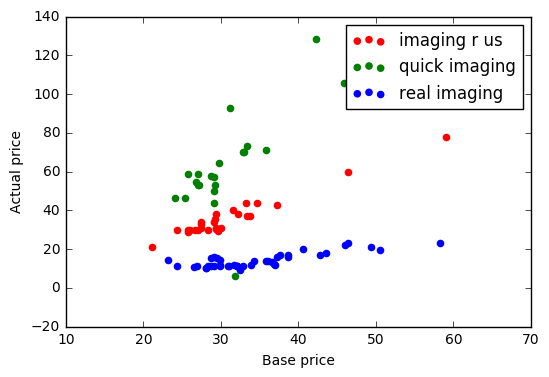

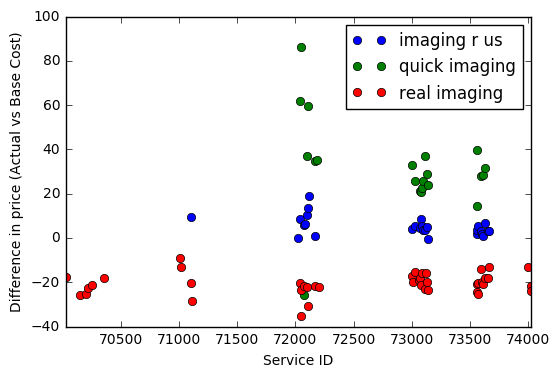

In [4]:
# Here we loop through the baselineCosts and imagingCenterCosts and find the typical cost associated with each unique service code 
uniqueServiceCodes = np.unique(imagingCenterCosts['SERVICE'].values);
facilities  = list(facilityIDs['FACILITY'].unique());
actualCosts = pd.DataFrame([],index=uniqueServiceCodes,columns=facilities);
baseCosts   = pd.DataFrame([],index=uniqueServiceCodes,columns=facilities);
for facility in facilities:
    IDCode = facilityIDs[facilityIDs['FACILITY']==facility]['LOC_ID'].values[0]
    #print(facility,IDCode)
    
    for serviceCode in uniqueServiceCodes:
        actualCosts.loc[serviceCode,facility] = imagingCenterCosts[(imagingCenterCosts['FACILITY']==facility)&(imagingCenterCosts['SERVICE']==serviceCode)].mean()[0]
        baseCosts.loc[  serviceCode,facility] =      baselineCosts[(     baselineCosts['LOC_ID'  ]==IDCode  )&(     baselineCosts['SERVICE']==serviceCode)].mean()[0];

# Plot the data and show in a table form
# PLOT 1: Scatter plot of Actual vs Base price
fig,ax=plt.subplots();
colors = 'rgb';
for i,facility in enumerate(facilities):
    plt.scatter(x=baseCosts.values[:,i],y=actualCosts.values[:,i],color=colors[i],label=facility);
ax.set_ylabel('Actual price')
ax.set_xlabel('Base price')
ax.legend()

# PLOT 2: Difference in price (Actual vs Base)
ax=(actualCosts-baseCosts).plot(style='o')
ax.set_ylabel('Difference in price (Actual vs Base Cost)')
ax.set_xlabel('Service ID')

# TABLE
print actualCosts-baseCosts

QUESTION 5: Can you model the observed prices as a function of the baseline prices ? Can you quantify the error in your model?
ANSWER 5: Yes, we can setup a linear regression model to test this relationship. I chose to use Ridge regression because it tends to be more robust as an "out-of-the-box" algorithm. I also chose at least initially to model each facility independently, as I was unsure whether the relationship between actual and base costs was consistent between the facilities. If I had more time, I would like to model the relationship. 

For model robustness, I also manually eliminated one data point for the quick imaging facility that had a dramatically lower actual price than the others. A perhaps better, but more time-consuming approach would be to compute the model on bootstrapped distributions. 

In [5]:
from sklearn.linear_model import RidgeCV

clf=RidgeCV(cv = 3,store_cv_values=False);
for i,facility in enumerate(facilities):
    # Get x,y data for model
    x = baseCosts.values[:,i].astype('float64');
    y = actualCosts.values[:,i].astype('float64');
    
    # Eliminate NaNs
    validEntries = (~np.isnan(x))&(~np.isnan(y));
    if i==1: # Manually removed one outlier
        validEntries[14] = False;
    x = x[validEntries];
    y = y[validEntries]
    
    # Reshape arrays to make them 1d
    x = x.reshape([x.size,1])
    y = y.reshape([y.size,1])
    
    clf.fit(x,y)
    print("Fitting a regression model to data for facility '{}': y = {:4.2f}*x+({:4.2f}), where R^2 = {:4.2f} and RMSE = {:4.2f}".format(facility,clf.coef_[0][0],clf.intercept_[0],clf.score(x,y),np.sqrt(np.mean((clf.predict(x)-y)**2))))

Fitting a regression model to data for facility 'imaging r us': y = 1.46*x+(-8.87), where R^2 = 0.95 and RMSE = 2.54
Fitting a regression model to data for facility 'quick imaging': y = 3.39*x+(-38.50), where R^2 = 0.76 and RMSE = 10.24
Fitting a regression model to data for facility 'real imaging': y = 0.42*x+(-0.43), where R^2 = 0.68 and RMSE = 2.15


Question 6: How can you use this model help improve the price estimates?

Answer 6: Because there is such a clear relationship between base costs and actual costs, the data in the base_costs.csv can be used to improve the fits of the original model (developed in Question 3) for making predictions on price for an X-ray procedure. However, before I would take advantage of the information, I would really want to investigate whether the regression model developed in Question 5 could be robustly fit using a single model, or if unique models were necessary for each facility. 

## Part 2: Predicting specialty labels of doctors 

Amino aims to help patients find doctors with unique specialties that are best suited for them. Specialty labels indicate the areas of expertise of a doctor. While there are several online databases that link doctors to specialties, they have limited coverage and are sometimes outdated. 

One of our projects at Amino is to assign specialty labels to doctors based on the services they provide as seen in the health care claims data. We want you to develop a model to assign specialty labels for doctors given (simulated) data about the services they provide and their patient age and gender. 

Relevant files:
-	physician_topic_frequency.csv has information about the frequency of different topics in a doctor’s claims data.
-	physician_patient_features.csv has some statistics about each doctor’s patient population. 
-	physician_specialty.csv has specialty labels for each doctor. 

We want you to explore this data and answer the following questions:
-	Build a predictive model for the specialty label associated with doctors. Which classification technique did you use and why?
-	Evaluate the performance of your algorithm. Which metrics did you choose and why? 
-	What insights can you gather from this model? 

Question: Build a predictive model for the specialty label associated with doctors. Which classification technique did you use and why?

Answer: Here I built a predictive model using a mix of different classifiers due to the ease in trying different models. I wanted to try a RandomForest with Gradient Boosting, since I was worried about overfitting, but I ran out of time for an implementation. However, basic linear classifiers, such as Ridge Classification and Support Vector Machine, appeared to provide good results. Logistic regression, a default choice of mine to try on a new classification problem, due to its speed, provided a decent performance, but gave some weird answers. I think the more robust classification of Support Vector Machine came from the non-linear boundaries and Ridge classification for having access to regularization (L-2 norm). 

------------

Question: Evaluate the performance of your algorithm. Which metrics did you choose and why?

Answer: One of the first things I noticed was the high number of features present in physician_topic_frequency.csv, which made me worry about overfitting. Thus, I tried a first implementation where Principal Component Analsysis (PCA) was used to reduce the dimensionality of the input data, but I did not find that helped. For actually building the predictive models, I used GridSearch to help me find the most optimal hyperparameter for each model (i.e. alpha or C). Also, to verify the performance of the model, I used 3-fold cross-validation, which returned stable results.

For the actual metric to evaluate model performance, I chose to start with a simple measure of accuracy (i.e. how frequent the algorithm predicted the doctor's speciality). However, if I had more time, I would have liked to try other measures like sensitivity/recall. Another softer metric was to evaluate what were the Top 10 features associated with each speciality. While Support Vector Machine and Ridge Classification provided features I would have associated with each speciality, I was very surprised to see that Logistic Regression associated features like hepatitis with gastroenterology and parkinsons-disease with cardiology. And in this sense, I think that Logistic Regression provided functionally less robust results than Support Vector Machine despite having a slightly higher accuracy.

------------

Question: What insights can you gather from this model?

Answer: Well one thing with the model is that we can verify is that there is enough data that performance on the model performs better without dimension reduction on the features. If I took a cutoff of explaining 95-99% of the features, I was finding between 50-75% model accuracy whereas model accuracy achieved 95% accuracy without dimension reduction with PCA.

Next, we can take advantage of this model to determine what factors are most likely to be associated with each speciality. I used this as a sanity to check, but I thought it was also be informative to see what features are most likely associated with each model. In the future, it would be interesting to create a profile, and determine whether some doctors are better described by more than one speciality. 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import KFold

# Read doctor data into Python
physicianPatientFeatures = pd.DataFrame.from_csv('physician_patient_features.csv').sort_index();
physicianSpecialty       = pd.DataFrame.from_csv('physician_specialty.csv'       );
physicianTopicFrequency  = pd.DataFrame.from_csv('physician_topic_frequency.csv' );

# Consider only data with common doctors in all 3 datasets
validDoctors = np.intersect1d(np.intersect1d(physicianPatientFeatures.index.unique(),\
                                             physicianSpecialty.index.unique()),     \
                                             physicianTopicFrequency.index.unique())
physicianPatientFeatures = physicianPatientFeatures.loc[validDoctors]
physicianSpecialty       = physicianSpecialty.loc[validDoctors]
physicianTopicFrequency  = physicianTopicFrequency.loc[validDoctors]

# Drop duplicate entries
physicianPatientFeatures = physicianPatientFeatures[~physicianPatientFeatures.index.duplicated(keep='first')]; # drops duplicate entry
physicianSpecialty       = physicianSpecialty[~physicianSpecialty.index.duplicated(keep='first')]; # drops duplicate entry
physicianTopicFrequency  = physicianTopicFrequency[~physicianTopicFrequency.index.duplicated(keep='first')]; # drops duplicate entry
                                         
# Verify that there are 4 specialities
#print physicianSpecialty['specialty'].unique()

# Convert specialty values to discrete integer values
yLabeled = physicianSpecialty['specialty'].values;
physicianSpecialtyEncoder = LabelEncoder();
y = physicianSpecialtyEncoder.fit_transform(yLabeled)

# Setup features. First will add the physicianTopicFrequency, compute PCA to reduce the dimensions (optional), and then add age and gender
usePCA = False;
X = physicianTopicFrequency.values.copy();
if usePCA: # use this to reduce the number of features in the physician topic frequency to a more manageable number (i.e. avoid overfitting)
    pca=PCA();
    pca.fit_transform(X)
    cumulativeVarianceExplained=np.cumsum(pca.explained_variance_/np.sum(pca.explained_variance_));
    nComponents = (cumulativeVarianceExplained>0.999).argmax();
    X = X[:,range(nComponents)]
    print("{} PCA factors explain 99.9% of the dataset variance".format(nComponents))
X = np.concatenate([X,physicianPatientFeatures[['median_age','frac_population_female']].values],axis=1);
    
# Select a model
for modelType in ['Logistic Regression','Support Vector Machine']:
    if modelType == 'Logistic Regression':
        clf = LogisticRegression();
        parameters = {'C':[10, 100, 1000, 10000, 100000, 1000000, 10000000]}
        estimator  = GridSearchCV(clf,parameters)
    if modelType == 'Ridge Classification':
        clf = RidgeClassifier();
        parameters = {'alpha':[1E-3, 1E-2, 1E-1, 1E0, 1E1, 1E2, 1E3]}
        estimator  = GridSearchCV(clf,parameters)
    elif modelType == 'Support Vector Machine':
        clf        = LinearSVC();
        parameters = {'C':[10, 100, 1000, 10000, 100000, 1000000]} 
        estimator  = GridSearchCV(clf,parameters)
    elif modelType == 'Random Forest':
        clf = GradientBoostingClassifier()
        parameters = {'learning_rate':[0.1], 'max_depth':[3,4], 'n_estimators':[50,100]}
        estimator  = GridSearchCV(clf,parameters)
    print("------------------------------------------------")
    print("Showing results for {} model ".format(modelType))
    print("------------------------------------------------")

    # Fit data to model using 3-fold cross-validation    
    n_folds = 3;
    kf = KFold(X.shape[0], n_folds=n_folds)
    modelAccuracy = np.zeros([n_folds,1]);
    for i, (train_index, test_index) in enumerate(kf):
        estimator.fit(X[train_index,:],y[train_index])
        modelAccuracy[i] = np.mean(estimator.predict(X[test_index,:])==y[test_index]); #np.sqrt(np.mean((clf.predict(X[test_index,:])-y[test_index])**2));
    print("Mean model accuracy using cross-validation (3-fold): {:4.2f}%".format(100*np.mean(modelAccuracy)))

    # Show the Top 10 features associated with each speciality
    topFeatures=10;
    mostAssociatedFeatures = estimator.best_estimator_.coef_.argsort(axis=1)[:,-(topFeatures+1):-1].T;
    featureNames = physicianTopicFrequency.columns;
    featureNames.append(np.array(['median_age','frac_population_female']).astype('object'))
    print("Top {} associated factors with each speciality".format(topFeatures))
    print pd.DataFrame(featureNames[mostAssociatedFeatures],index=range(topFeatures),columns=physicianSpecialtyEncoder.classes_)  

------------------------------------------------
Showing results for Logistic Regression model 
------------------------------------------------
Mean model accuracy using cross-validation (3-fold): 95.42%
Top 10 associated factors with each speciality
                 CARDIOVASCULAR DISEASE (CARDIOLOGY)  \
0                       proc_cardiac-catheterization   
1                                        diag_sepsis   
2                                      diag_weakness   
3                                  proc_hemodialysis   
4                            diag_parkinsons-disease   
5              diag_high-blood-pressure-hypertension   
6                         diag_heart-valve-condition   
7                                 diag_heart-disease   
8  proc_NO TOPIC - cardiac-stress-test_procedure_...   
9                   diag_coronary-artery-disease-cad   

                                GASTROENTEROLOGY  \
0           proc_peripheral-vascular-disease-pvd   
1                          